Loading the dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

file_path = '../../data_all.csv'
dataset = pd.read_csv(file_path, index_col=0)

scaler = StandardScaler()
rescaled_dataset = scaler.fit_transform(dataset)

In [4]:
dataset.columns

Index(['LCOM5', 'WMC', 'CBO', 'NOI_x', 'RFC', 'CLOC_x', 'DIT', 'NOA', 'NOC',
       'NOD', 'NOP', 'LOC_x', 'LLOC_x', 'NM', 'NLM', 'NOS_x', 'TLOC_x',
       'TLLOC_x', 'TNM', 'TNLM', 'TNOS_x', 'McCC', 'NOI_y', 'CLOC_y', 'DLOC',
       'TCLOC', 'LLOC_y', 'LOC_y', 'NOS_y', 'NUMPAR', 'TLLOC_y', 'TLOC_y',
       'TNOS_y', 'HCPL', 'HDIF', 'HEFF', 'HNDB', 'HPL', 'HPV', 'HTRP', 'HVOL',
       'MI'],
      dtype='object')

Define fitness func

In [5]:
def sammon_error(high_dim_data, low_dim_data):
    high_distances = np.linalg.norm(high_dim_data[:, None] - high_dim_data, axis=2)
    low_distances = np.linalg.norm(low_dim_data[:, None] - low_dim_data, axis=2)
    high_dist_sum = np.sum(high_distances)
    sammon_error_value = np.sum(((high_distances - low_distances) ** 2) / (high_distances + 1e-9)) / high_dist_sum
    return sammon_error_value

First try of the algorithm to see how well it works with quite lax parameters.

In [6]:
num_features = rescaled_dataset.shape[1]
num_food_sources = 10
MR = 0.1
MAX_LIMIT = 5
max_iterations = 50
food_sources = np.random.randint(2, size=(num_food_sources, num_features))
limits = np.zeros(num_food_sources)

Main body of the algorithm 🐝🐝🐝

In [7]:
from tqdm import tqdm

def reduce_features(data, binary_vector):
    selected_features = data[:, binary_vector == 1]
    return selected_features

best_solution = None
best_error = float('inf')

for iteration in tqdm(range(max_iterations)):
    for i in range(num_food_sources):
        subset_data = reduce_features(rescaled_dataset, food_sources[i])
        current_error = sammon_error(rescaled_dataset, subset_data)
        neighbor = food_sources[i].copy()
        for j in range(num_features):
            if np.random.rand() < MR:
                neighbor[j] = 1 if neighbor[j] == 0 else 0
        neighbor_subset_data = reduce_features(rescaled_dataset, neighbor)
        neighbor_error = sammon_error(rescaled_dataset, neighbor_subset_data)
        if neighbor_error < current_error:
            food_sources[i] = neighbor
            limits[i] = 0
        else:
            limits[i] += 1
        if current_error < best_error:
            best_solution = food_sources[i]
            best_error = current_error
    for i in range(num_food_sources):
        if limits[i] >= MAX_LIMIT:
            food_sources[i] = np.random.randint(2, size=num_features)
            limits[i] = 0

100%|██████████| 50/50 [00:02<00:00, 17.55it/s]


In [8]:
best_reduced_dataset = reduce_features(rescaled_dataset, best_solution)

best_solution, best_error, best_reduced_dataset

(array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1],
       dtype=int32),
 np.float64(0.014281958196591652),
 array([[ 0.5842667 , -1.08422948, -0.13531593, ...,  0.77174449,
          0.00717949, -0.74290012],
        [ 0.46706204, -0.83604403,  0.14070586, ...,  0.23272362,
          0.568463  ,  0.37780319],
        [ 0.88489124,  1.47200872,  1.0220263 , ...,  0.11104476,
          0.18950526, -1.54320678],
        ...,
        [ 0.92015849, -0.28951465,  0.0219641 , ...,  0.18748876,
         -0.42509594, -0.54107482],
        [ 1.05460137,  0.04674857, -0.207446  , ...,  2.09114766,
          4.04826809, -0.23995617],
        [-0.41569026,  0.89165304,  0.872809  , ..., -1.36469344,
         -0.89864583,  1.13755203]]))

Let's see how Sammon error depends on algorithm parameter choice.

In [9]:
param_combinations = {
    'num_food_sources': [5, 10, 20],
    'MR': [0.05, 0.1, 0.2],
    'MAX_LIMIT': [3, 5, 10],
    'max_iterations': [20, 50, 100]
}

In [25]:
def abc_run(num_food_sources, MR, MAX_LIMIT, max_iterations):
    food_sources = np.random.randint(2, size=(num_food_sources, num_features))
    limits = np.zeros(num_food_sources)
    # best_solution = None
    best_error = float('inf')
    error_history = []

    for iteration in tqdm(range(max_iterations)):
        for i in range(num_food_sources):
            subset_data = reduce_features(rescaled_dataset, food_sources[i])
            current_error = sammon_error(rescaled_dataset, subset_data)
            neighbor = food_sources[i].copy()
            for j in range(num_features):
                if np.random.rand() < MR:
                    neighbor[j] = 1 if neighbor[j] == 0 else 0

            neighbor_subset_data = reduce_features(rescaled_dataset, neighbor)
            neighbor_error = sammon_error(rescaled_dataset, neighbor_subset_data)

            if neighbor_error < current_error:
                food_sources[i] = neighbor
                limits[i] = 0
            else:
                limits[i] += 1

            if current_error < best_error:
                # best_solution = food_sources[i]
                best_error = current_error

        for i in range(num_food_sources):
            if limits[i] >= MAX_LIMIT:
                food_sources[i] = np.random.randint(2, size=num_features)
                limits[i] = 0

        error_history.append(best_error)

    return error_history

In [26]:
results = {}
for num_sources in param_combinations['num_food_sources']:
    for mr in param_combinations['MR']:
        for max_limit in param_combinations['MAX_LIMIT']:
            for iterations in param_combinations['max_iterations']:
                key = f"num_food_sources={num_sources}, MR={mr}, MAX_LIMIT={max_limit}, iterations={iterations}"
                print(f"Running with: {key}")
                error_history = abc_run(num_sources, mr, max_limit, iterations)
                results[key] = error_history

Running with: num_food_sources=5, MR=0.05, MAX_LIMIT=3, iterations=20


100%|██████████| 20/20 [00:00<00:00, 27.94it/s]


Running with: num_food_sources=5, MR=0.05, MAX_LIMIT=3, iterations=50


100%|██████████| 50/50 [00:01<00:00, 27.72it/s]


Running with: num_food_sources=5, MR=0.05, MAX_LIMIT=3, iterations=100


100%|██████████| 100/100 [00:03<00:00, 31.52it/s]


Running with: num_food_sources=5, MR=0.05, MAX_LIMIT=5, iterations=20


100%|██████████| 20/20 [00:00<00:00, 31.64it/s]


Running with: num_food_sources=5, MR=0.05, MAX_LIMIT=5, iterations=50


100%|██████████| 50/50 [00:02<00:00, 22.42it/s]


Running with: num_food_sources=5, MR=0.05, MAX_LIMIT=5, iterations=100


100%|██████████| 100/100 [00:04<00:00, 23.16it/s]


Running with: num_food_sources=5, MR=0.05, MAX_LIMIT=10, iterations=20


100%|██████████| 20/20 [00:00<00:00, 33.44it/s]


Running with: num_food_sources=5, MR=0.05, MAX_LIMIT=10, iterations=50


100%|██████████| 50/50 [00:01<00:00, 29.84it/s]


Running with: num_food_sources=5, MR=0.05, MAX_LIMIT=10, iterations=100


100%|██████████| 100/100 [00:03<00:00, 32.23it/s]


Running with: num_food_sources=5, MR=0.1, MAX_LIMIT=3, iterations=20


100%|██████████| 20/20 [00:00<00:00, 33.91it/s]


Running with: num_food_sources=5, MR=0.1, MAX_LIMIT=3, iterations=50


100%|██████████| 50/50 [00:01<00:00, 30.65it/s]


Running with: num_food_sources=5, MR=0.1, MAX_LIMIT=3, iterations=100


100%|██████████| 100/100 [00:02<00:00, 34.13it/s]


Running with: num_food_sources=5, MR=0.1, MAX_LIMIT=5, iterations=20


100%|██████████| 20/20 [00:00<00:00, 34.66it/s]


Running with: num_food_sources=5, MR=0.1, MAX_LIMIT=5, iterations=50


100%|██████████| 50/50 [00:01<00:00, 33.87it/s]


Running with: num_food_sources=5, MR=0.1, MAX_LIMIT=5, iterations=100


100%|██████████| 100/100 [00:02<00:00, 34.35it/s]


Running with: num_food_sources=5, MR=0.1, MAX_LIMIT=10, iterations=20


100%|██████████| 20/20 [00:00<00:00, 29.30it/s]


Running with: num_food_sources=5, MR=0.1, MAX_LIMIT=10, iterations=50


100%|██████████| 50/50 [00:01<00:00, 32.92it/s]


Running with: num_food_sources=5, MR=0.1, MAX_LIMIT=10, iterations=100


100%|██████████| 100/100 [00:02<00:00, 34.24it/s]


Running with: num_food_sources=5, MR=0.2, MAX_LIMIT=3, iterations=20


100%|██████████| 20/20 [00:00<00:00, 35.13it/s]


Running with: num_food_sources=5, MR=0.2, MAX_LIMIT=3, iterations=50


100%|██████████| 50/50 [00:01<00:00, 35.41it/s]


Running with: num_food_sources=5, MR=0.2, MAX_LIMIT=3, iterations=100


100%|██████████| 100/100 [00:02<00:00, 35.53it/s]


Running with: num_food_sources=5, MR=0.2, MAX_LIMIT=5, iterations=20


100%|██████████| 20/20 [00:00<00:00, 34.69it/s]


Running with: num_food_sources=5, MR=0.2, MAX_LIMIT=5, iterations=50


100%|██████████| 50/50 [00:01<00:00, 34.77it/s]


Running with: num_food_sources=5, MR=0.2, MAX_LIMIT=5, iterations=100


100%|██████████| 100/100 [00:02<00:00, 34.82it/s]


Running with: num_food_sources=5, MR=0.2, MAX_LIMIT=10, iterations=20


100%|██████████| 20/20 [00:00<00:00, 35.30it/s]


Running with: num_food_sources=5, MR=0.2, MAX_LIMIT=10, iterations=50


100%|██████████| 50/50 [00:01<00:00, 34.68it/s]


Running with: num_food_sources=5, MR=0.2, MAX_LIMIT=10, iterations=100


100%|██████████| 100/100 [00:02<00:00, 34.44it/s]


Running with: num_food_sources=10, MR=0.05, MAX_LIMIT=3, iterations=20


100%|██████████| 20/20 [00:01<00:00, 18.53it/s]


Running with: num_food_sources=10, MR=0.05, MAX_LIMIT=3, iterations=50


100%|██████████| 50/50 [00:02<00:00, 18.00it/s]


Running with: num_food_sources=10, MR=0.05, MAX_LIMIT=3, iterations=100


100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


Running with: num_food_sources=10, MR=0.05, MAX_LIMIT=5, iterations=20


100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Running with: num_food_sources=10, MR=0.05, MAX_LIMIT=5, iterations=50


100%|██████████| 50/50 [00:03<00:00, 12.91it/s]


Running with: num_food_sources=10, MR=0.05, MAX_LIMIT=5, iterations=100


100%|██████████| 100/100 [00:06<00:00, 14.54it/s]


Running with: num_food_sources=10, MR=0.05, MAX_LIMIT=10, iterations=20


100%|██████████| 20/20 [00:01<00:00, 16.36it/s]


Running with: num_food_sources=10, MR=0.05, MAX_LIMIT=10, iterations=50


100%|██████████| 50/50 [00:04<00:00, 11.99it/s]


Running with: num_food_sources=10, MR=0.05, MAX_LIMIT=10, iterations=100


100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


Running with: num_food_sources=10, MR=0.1, MAX_LIMIT=3, iterations=20


100%|██████████| 20/20 [00:01<00:00, 18.10it/s]


Running with: num_food_sources=10, MR=0.1, MAX_LIMIT=3, iterations=50


100%|██████████| 50/50 [00:04<00:00, 12.28it/s]


Running with: num_food_sources=10, MR=0.1, MAX_LIMIT=3, iterations=100


100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


Running with: num_food_sources=10, MR=0.1, MAX_LIMIT=5, iterations=20


100%|██████████| 20/20 [00:01<00:00, 16.89it/s]


Running with: num_food_sources=10, MR=0.1, MAX_LIMIT=5, iterations=50


100%|██████████| 50/50 [00:04<00:00, 10.43it/s]


Running with: num_food_sources=10, MR=0.1, MAX_LIMIT=5, iterations=100


100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


Running with: num_food_sources=10, MR=0.1, MAX_LIMIT=10, iterations=20


100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Running with: num_food_sources=10, MR=0.1, MAX_LIMIT=10, iterations=50


100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


Running with: num_food_sources=10, MR=0.1, MAX_LIMIT=10, iterations=100


100%|██████████| 100/100 [00:06<00:00, 15.31it/s]


Running with: num_food_sources=10, MR=0.2, MAX_LIMIT=3, iterations=20


100%|██████████| 20/20 [00:01<00:00, 12.45it/s]


Running with: num_food_sources=10, MR=0.2, MAX_LIMIT=3, iterations=50


100%|██████████| 50/50 [00:03<00:00, 13.24it/s]


Running with: num_food_sources=10, MR=0.2, MAX_LIMIT=3, iterations=100


100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Running with: num_food_sources=10, MR=0.2, MAX_LIMIT=5, iterations=20


100%|██████████| 20/20 [00:01<00:00, 15.44it/s]


Running with: num_food_sources=10, MR=0.2, MAX_LIMIT=5, iterations=50


100%|██████████| 50/50 [00:03<00:00, 14.44it/s]


Running with: num_food_sources=10, MR=0.2, MAX_LIMIT=5, iterations=100


100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


Running with: num_food_sources=10, MR=0.2, MAX_LIMIT=10, iterations=20


100%|██████████| 20/20 [00:01<00:00, 17.18it/s]


Running with: num_food_sources=10, MR=0.2, MAX_LIMIT=10, iterations=50


100%|██████████| 50/50 [00:03<00:00, 16.37it/s]


Running with: num_food_sources=10, MR=0.2, MAX_LIMIT=10, iterations=100


100%|██████████| 100/100 [00:06<00:00, 14.55it/s]


Running with: num_food_sources=20, MR=0.05, MAX_LIMIT=3, iterations=20


100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Running with: num_food_sources=20, MR=0.05, MAX_LIMIT=3, iterations=50


100%|██████████| 50/50 [00:05<00:00,  8.47it/s]


Running with: num_food_sources=20, MR=0.05, MAX_LIMIT=3, iterations=100


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


Running with: num_food_sources=20, MR=0.05, MAX_LIMIT=5, iterations=20


100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Running with: num_food_sources=20, MR=0.05, MAX_LIMIT=5, iterations=50


100%|██████████| 50/50 [00:05<00:00,  8.38it/s]


Running with: num_food_sources=20, MR=0.05, MAX_LIMIT=5, iterations=100


100%|██████████| 100/100 [00:11<00:00,  8.69it/s]


Running with: num_food_sources=20, MR=0.05, MAX_LIMIT=10, iterations=20


100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Running with: num_food_sources=20, MR=0.05, MAX_LIMIT=10, iterations=50


100%|██████████| 50/50 [00:05<00:00,  8.40it/s]


Running with: num_food_sources=20, MR=0.05, MAX_LIMIT=10, iterations=100


100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


Running with: num_food_sources=20, MR=0.1, MAX_LIMIT=3, iterations=20


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Running with: num_food_sources=20, MR=0.1, MAX_LIMIT=3, iterations=50


100%|██████████| 50/50 [00:06<00:00,  8.33it/s]


Running with: num_food_sources=20, MR=0.1, MAX_LIMIT=3, iterations=100


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]


Running with: num_food_sources=20, MR=0.1, MAX_LIMIT=5, iterations=20


100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Running with: num_food_sources=20, MR=0.1, MAX_LIMIT=5, iterations=50


100%|██████████| 50/50 [00:05<00:00,  8.36it/s]


Running with: num_food_sources=20, MR=0.1, MAX_LIMIT=5, iterations=100


100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Running with: num_food_sources=20, MR=0.1, MAX_LIMIT=10, iterations=20


100%|██████████| 20/20 [00:03<00:00,  6.09it/s]


Running with: num_food_sources=20, MR=0.1, MAX_LIMIT=10, iterations=50


100%|██████████| 50/50 [00:05<00:00,  8.36it/s]


Running with: num_food_sources=20, MR=0.1, MAX_LIMIT=10, iterations=100


100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


Running with: num_food_sources=20, MR=0.2, MAX_LIMIT=3, iterations=20


100%|██████████| 20/20 [00:02<00:00,  7.19it/s]


Running with: num_food_sources=20, MR=0.2, MAX_LIMIT=3, iterations=50


100%|██████████| 50/50 [00:06<00:00,  8.22it/s]


Running with: num_food_sources=20, MR=0.2, MAX_LIMIT=3, iterations=100


100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Running with: num_food_sources=20, MR=0.2, MAX_LIMIT=5, iterations=20


100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Running with: num_food_sources=20, MR=0.2, MAX_LIMIT=5, iterations=50


100%|██████████| 50/50 [00:06<00:00,  8.26it/s]


Running with: num_food_sources=20, MR=0.2, MAX_LIMIT=5, iterations=100


100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


Running with: num_food_sources=20, MR=0.2, MAX_LIMIT=10, iterations=20


100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


Running with: num_food_sources=20, MR=0.2, MAX_LIMIT=10, iterations=50


100%|██████████| 50/50 [00:06<00:00,  7.25it/s]


Running with: num_food_sources=20, MR=0.2, MAX_LIMIT=10, iterations=100


100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


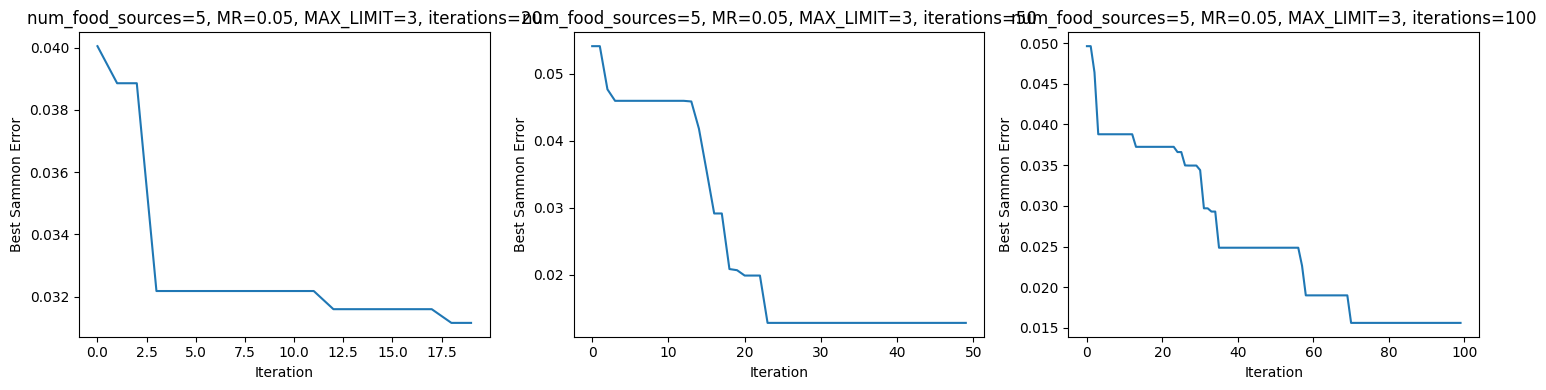

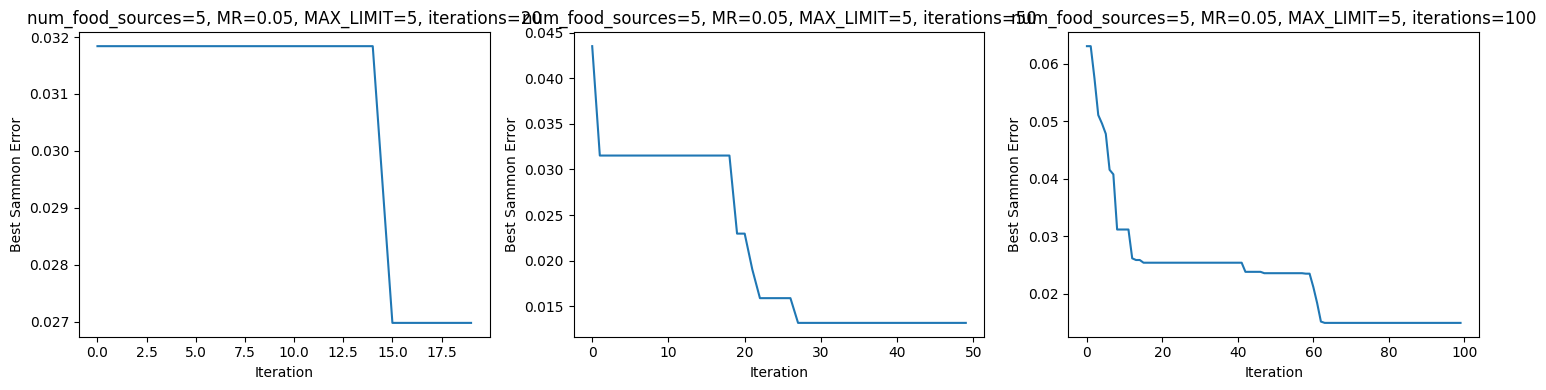

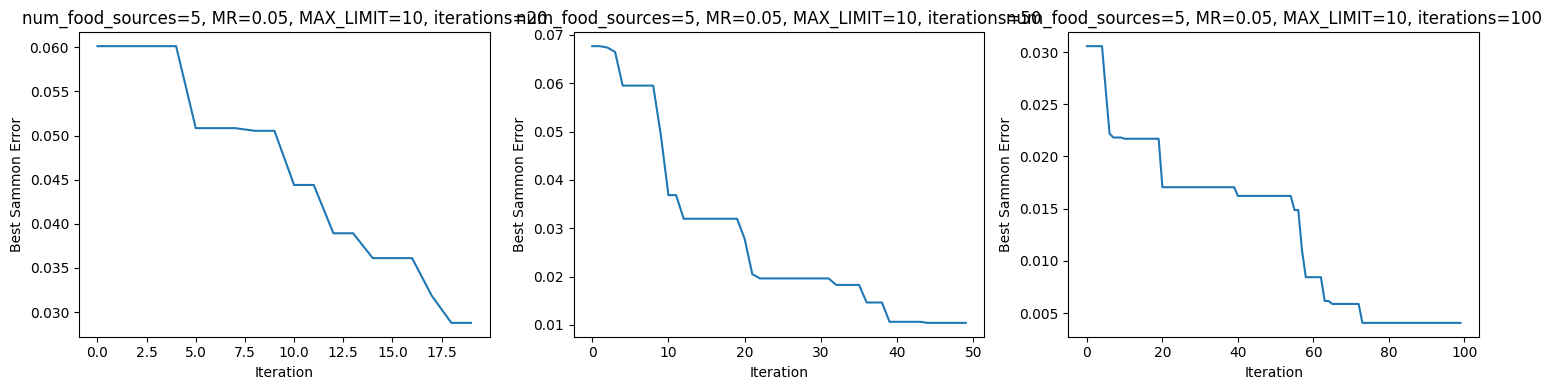

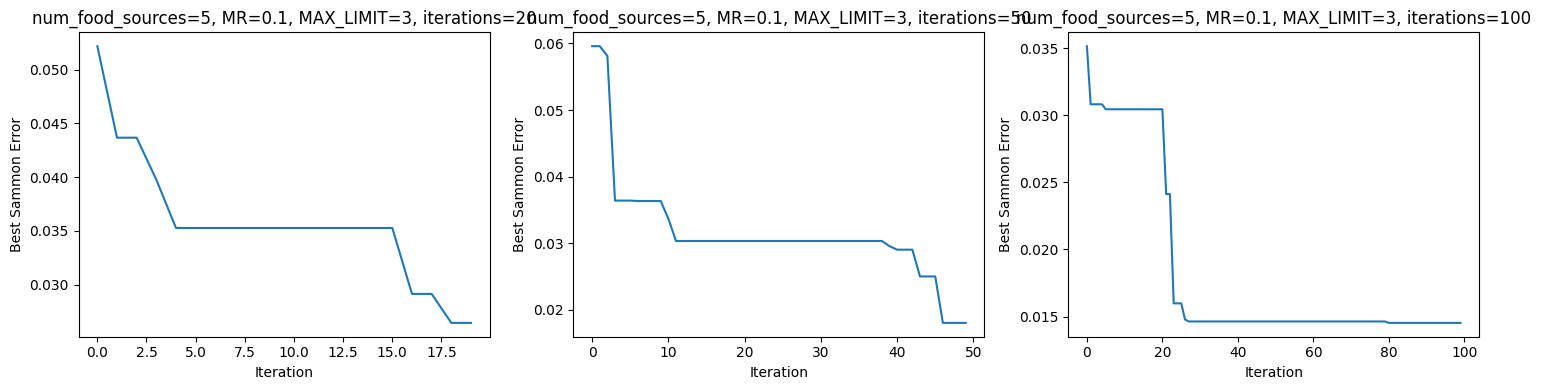

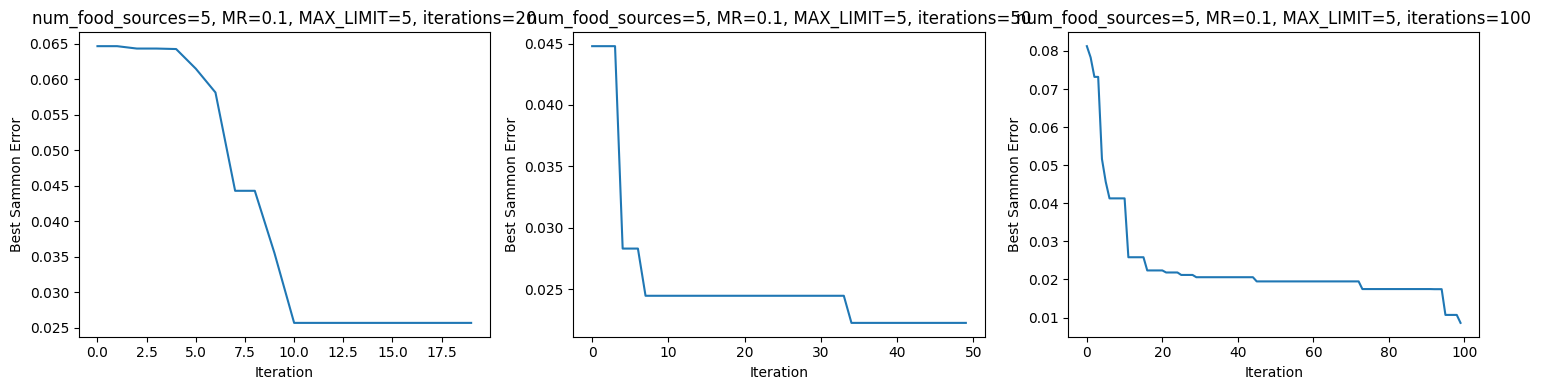

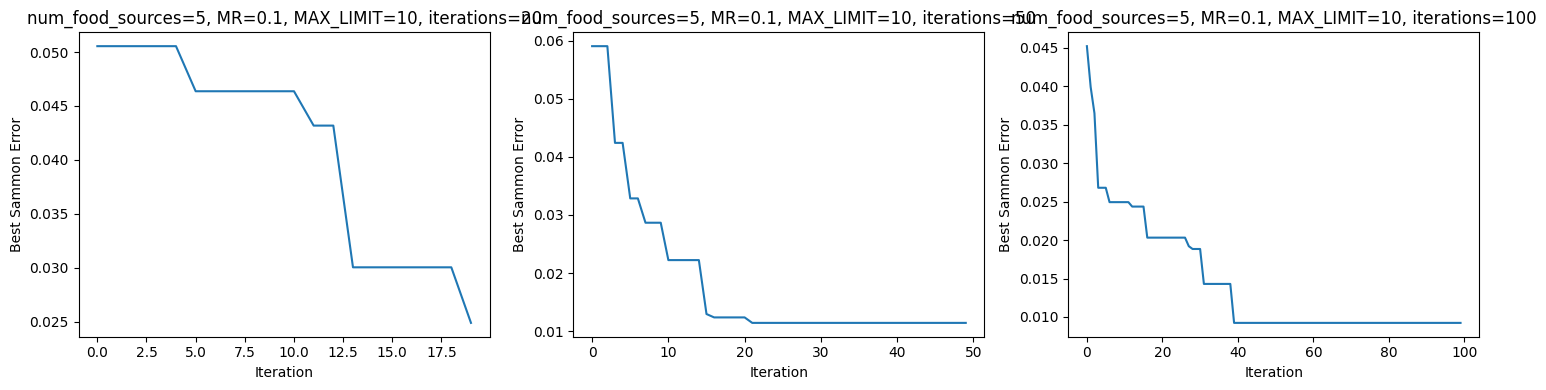

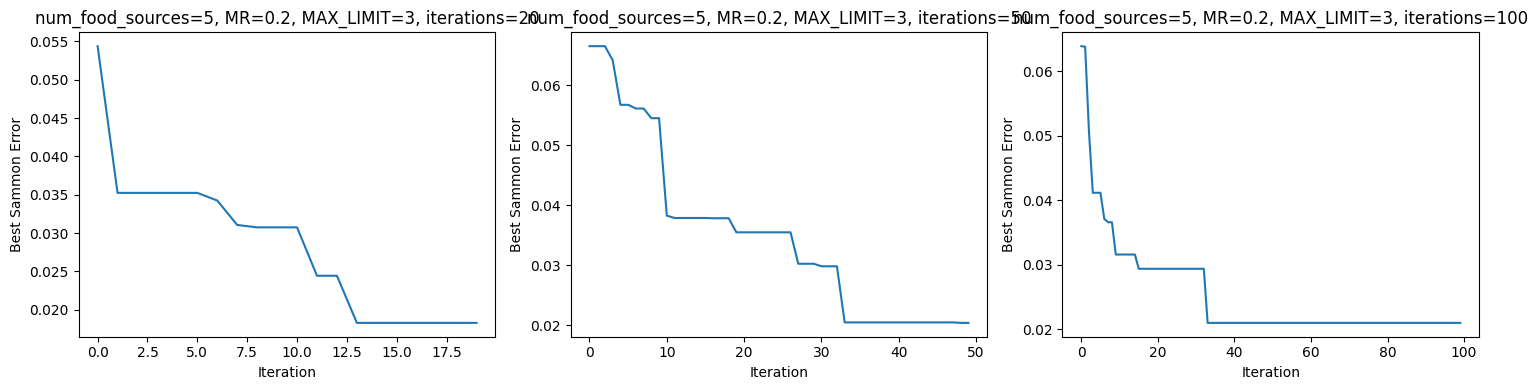

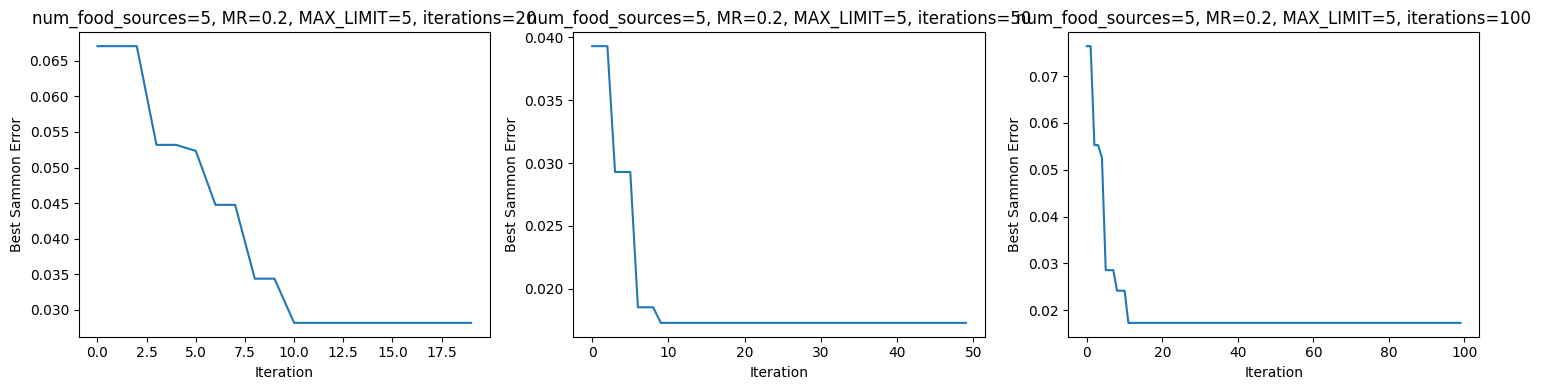

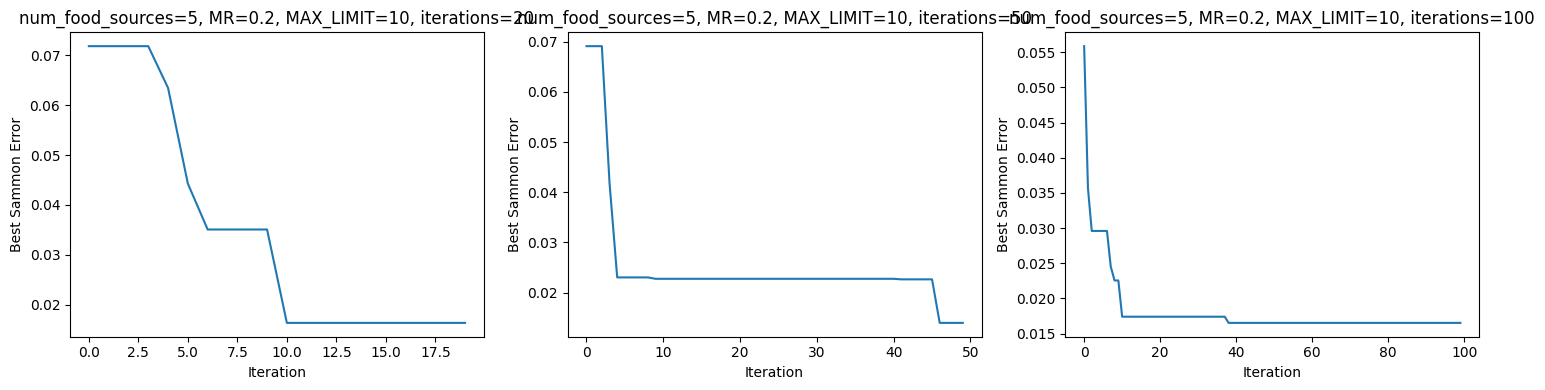

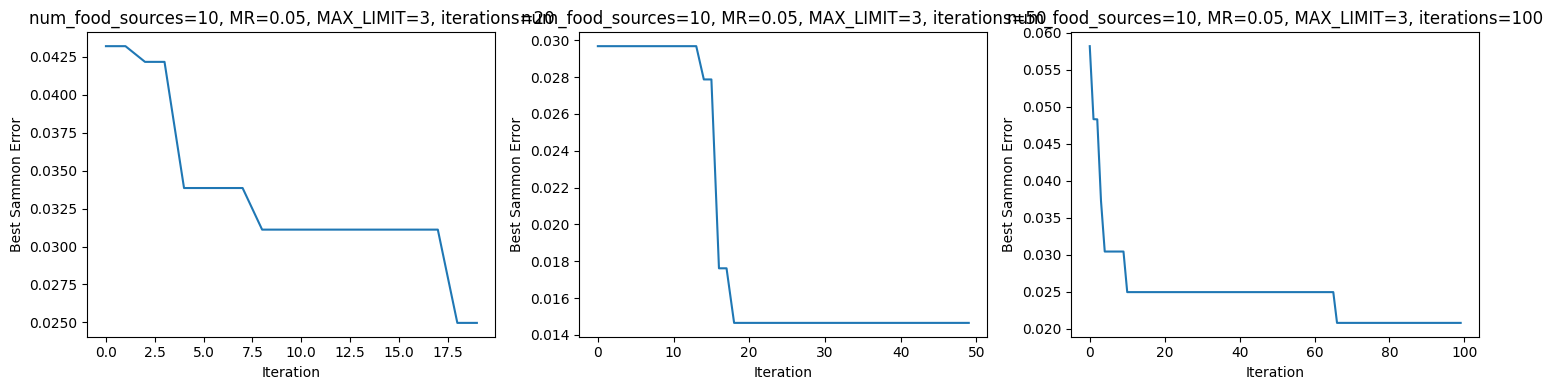

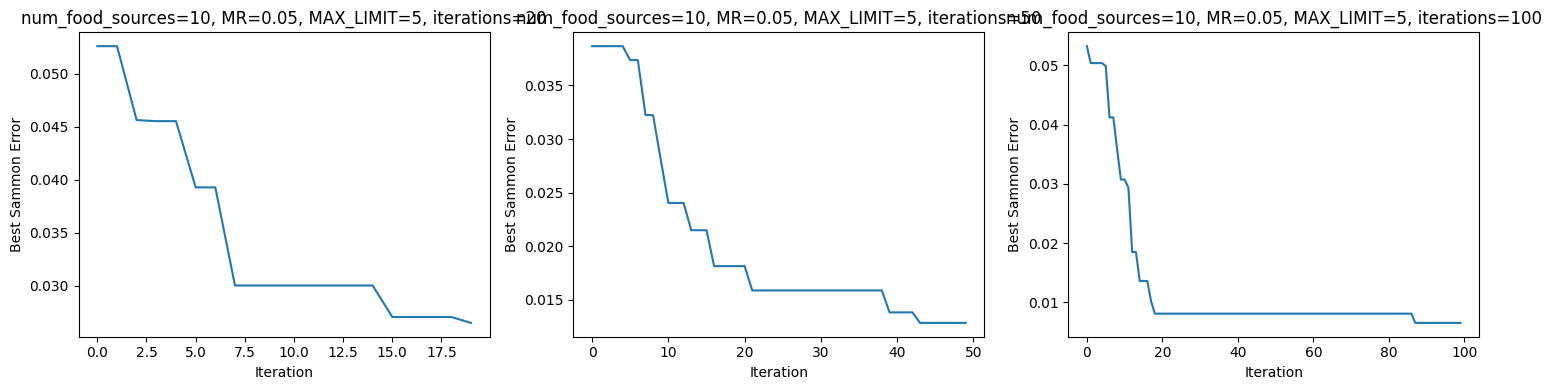

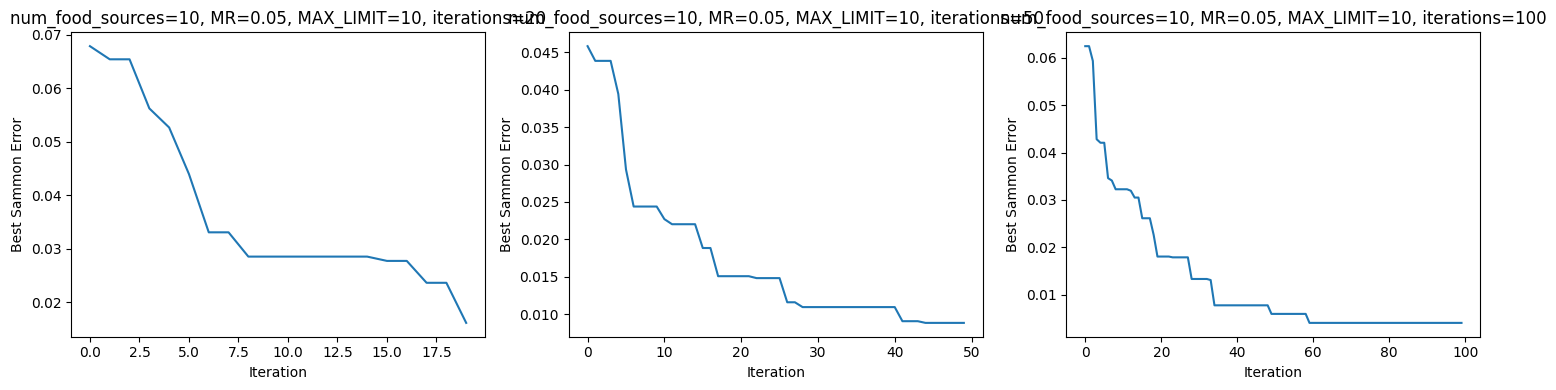

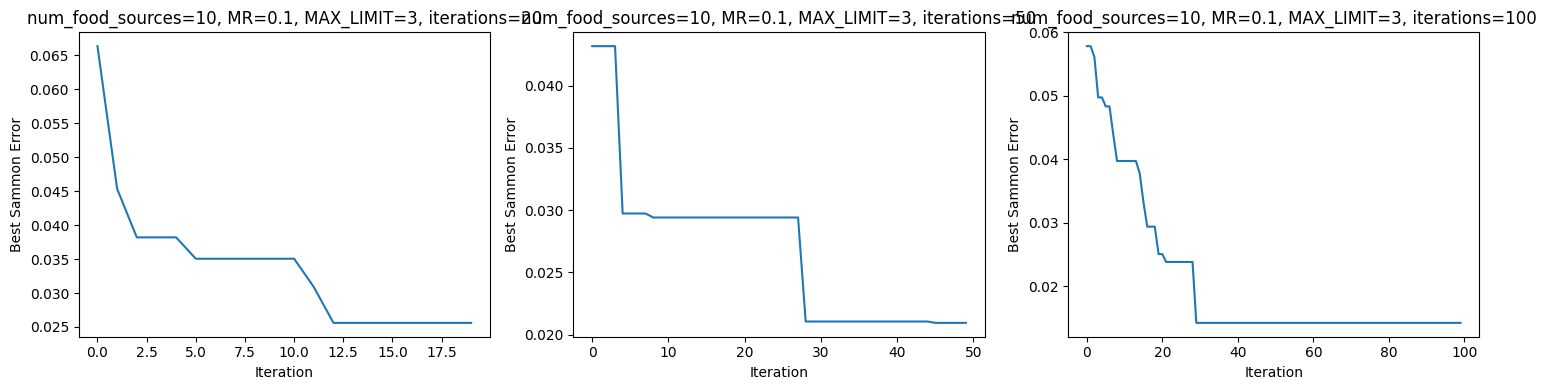

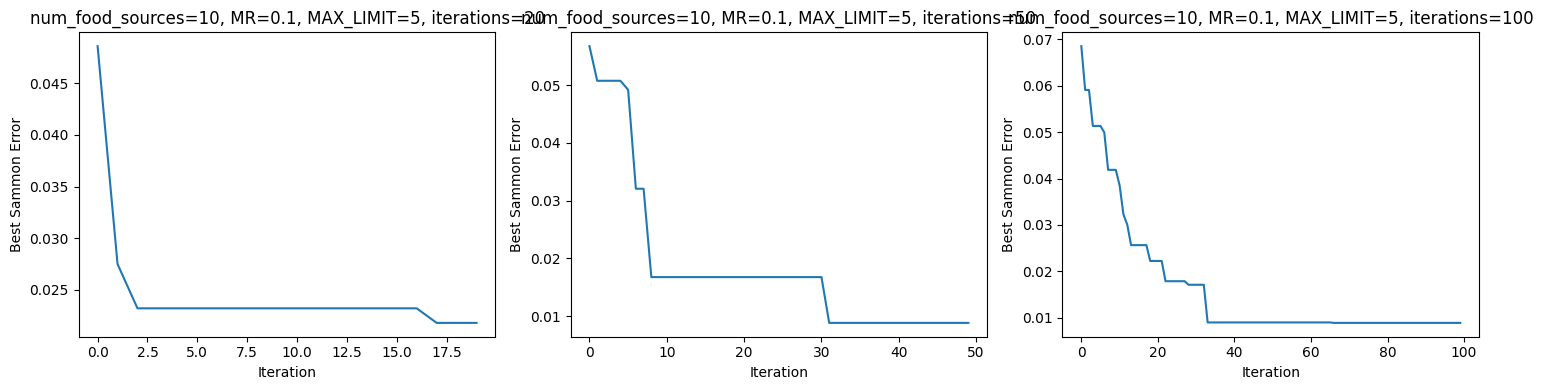

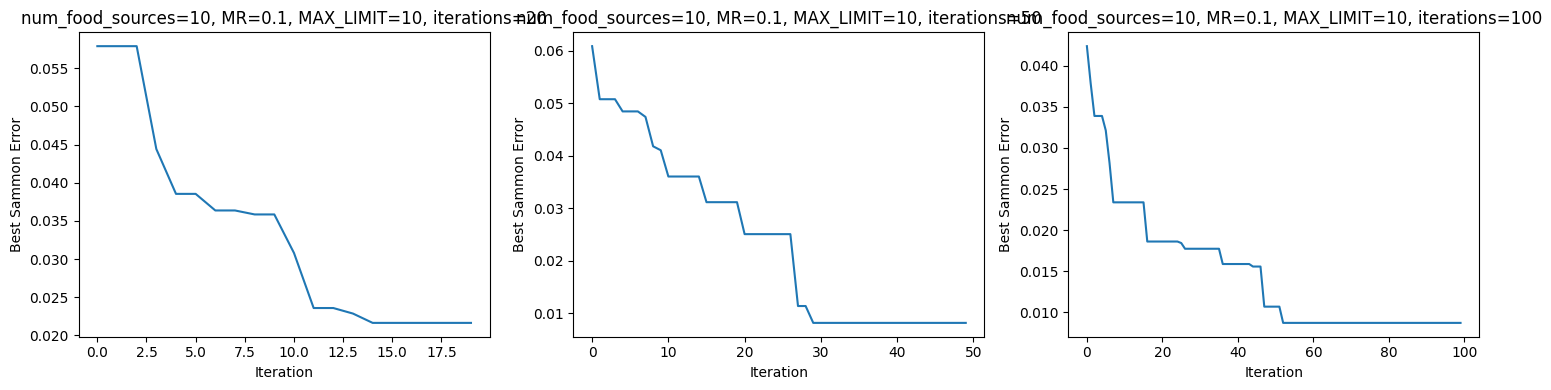

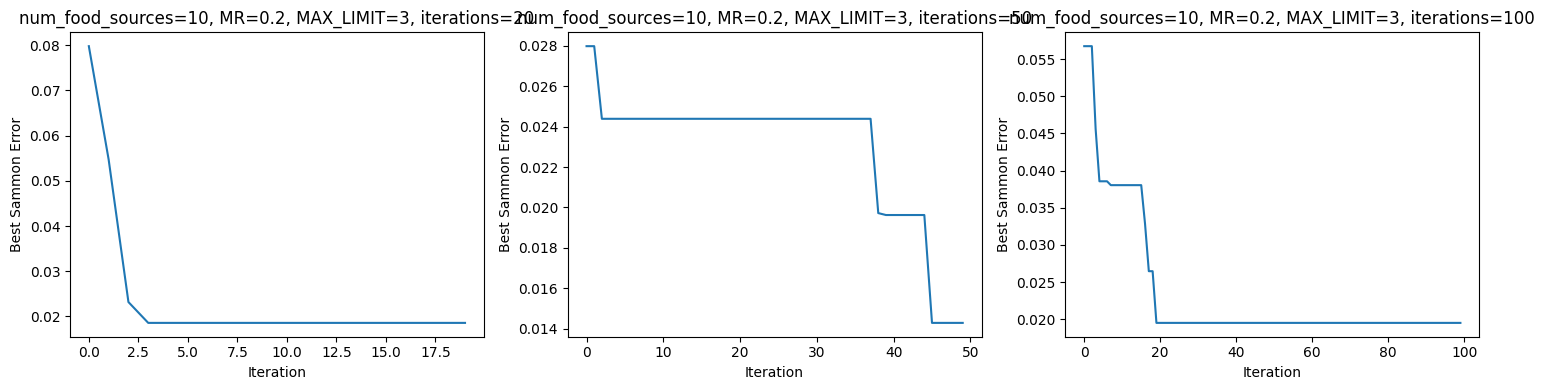

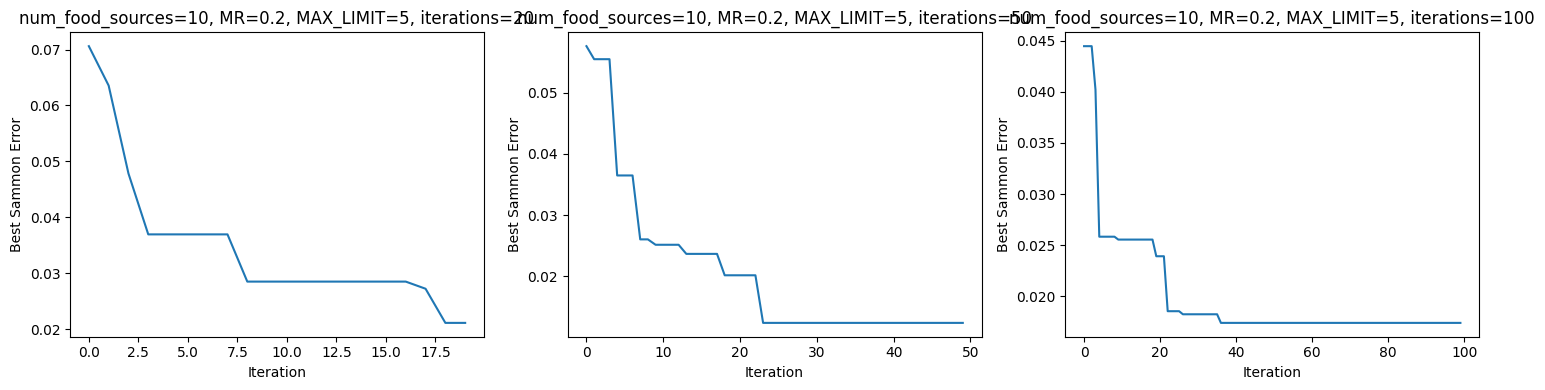

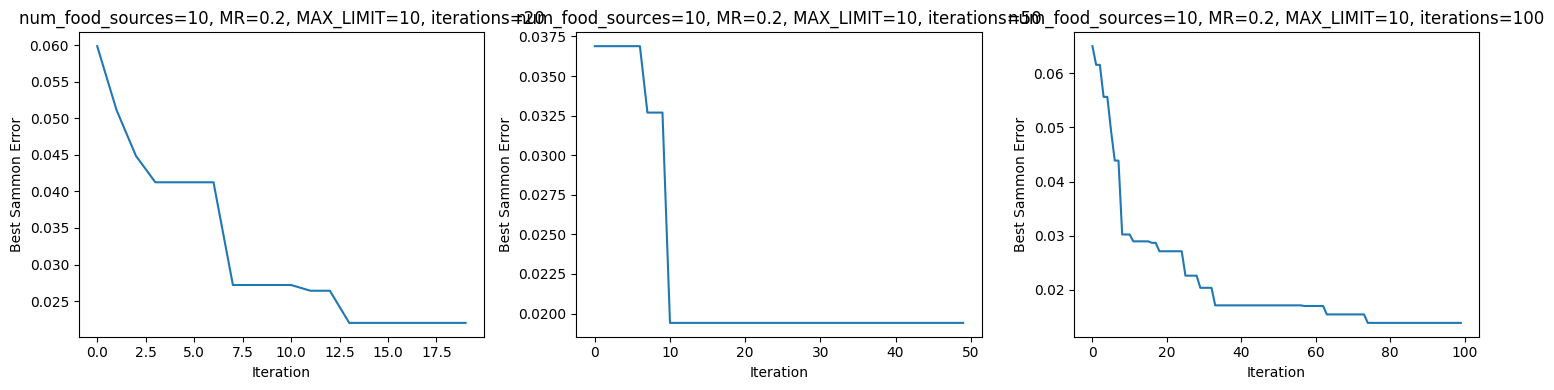

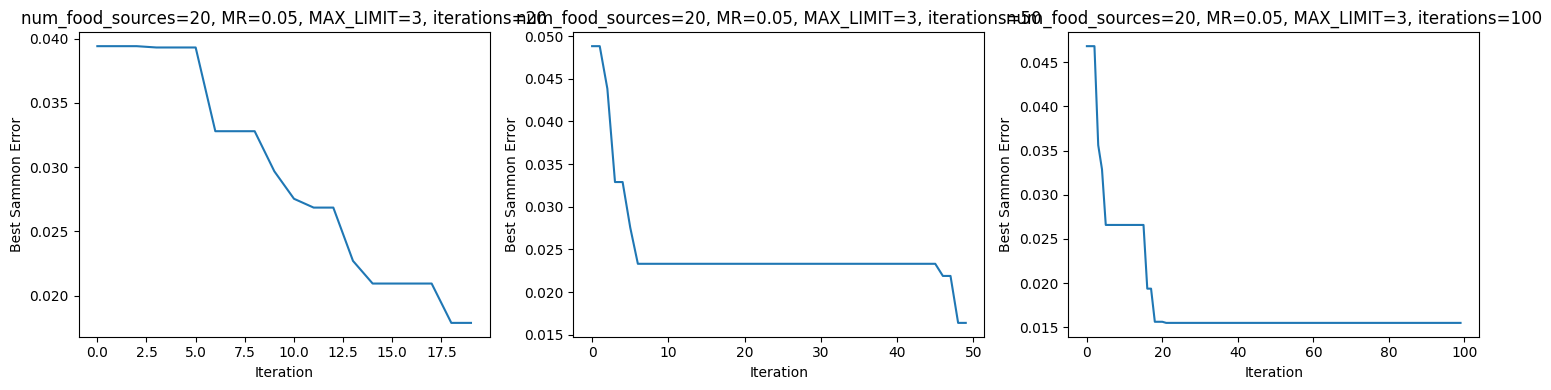

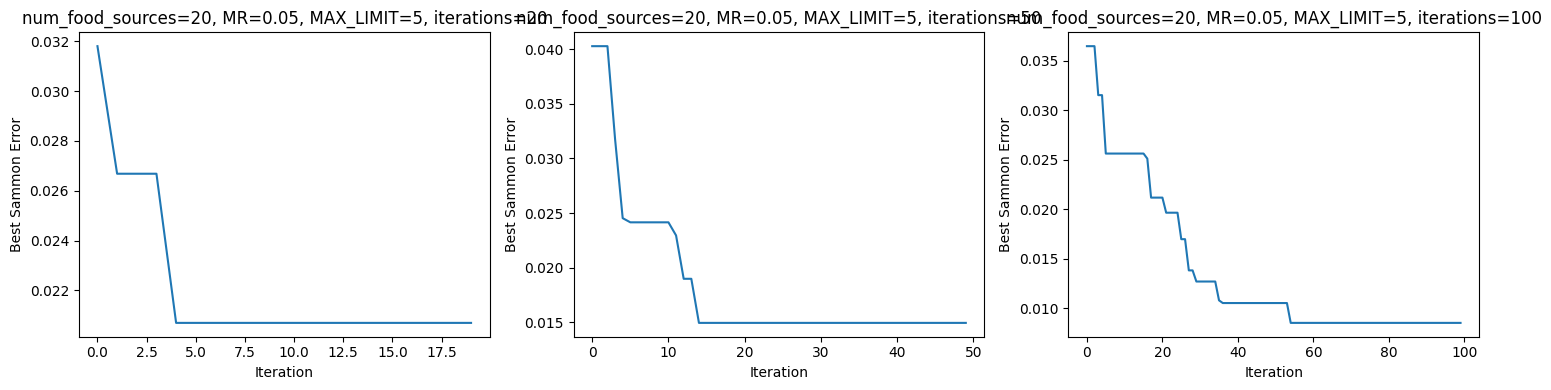

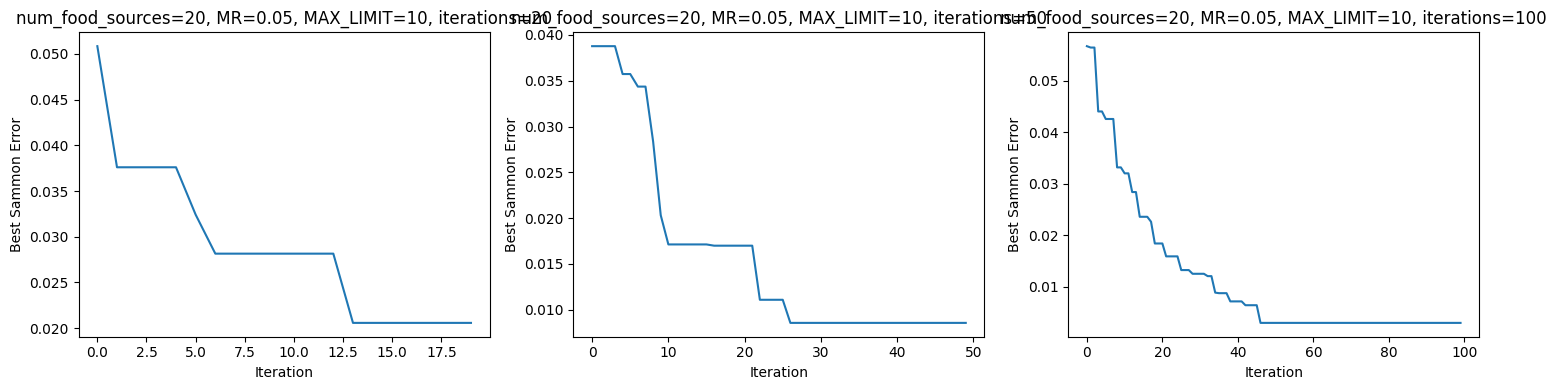

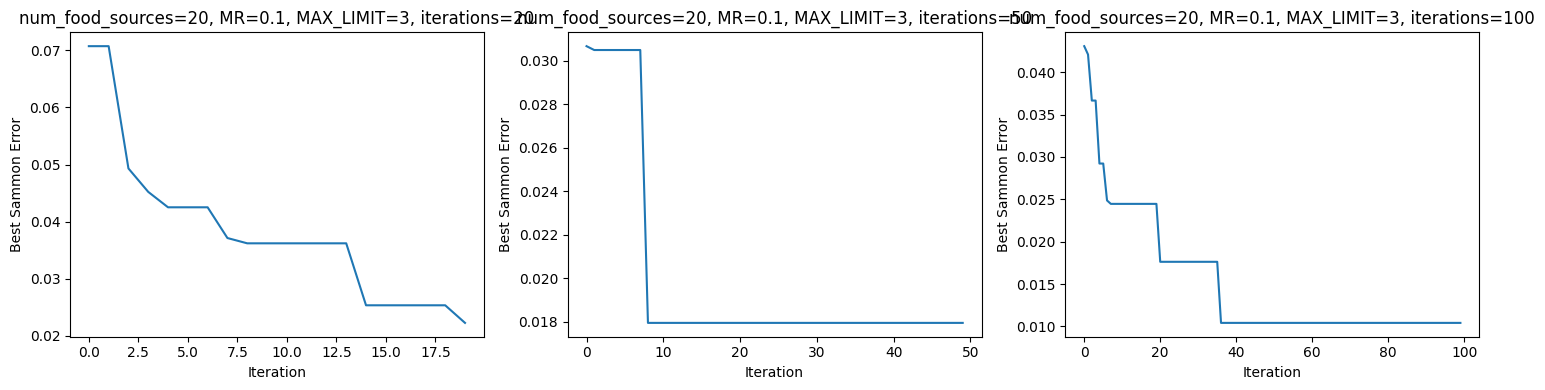

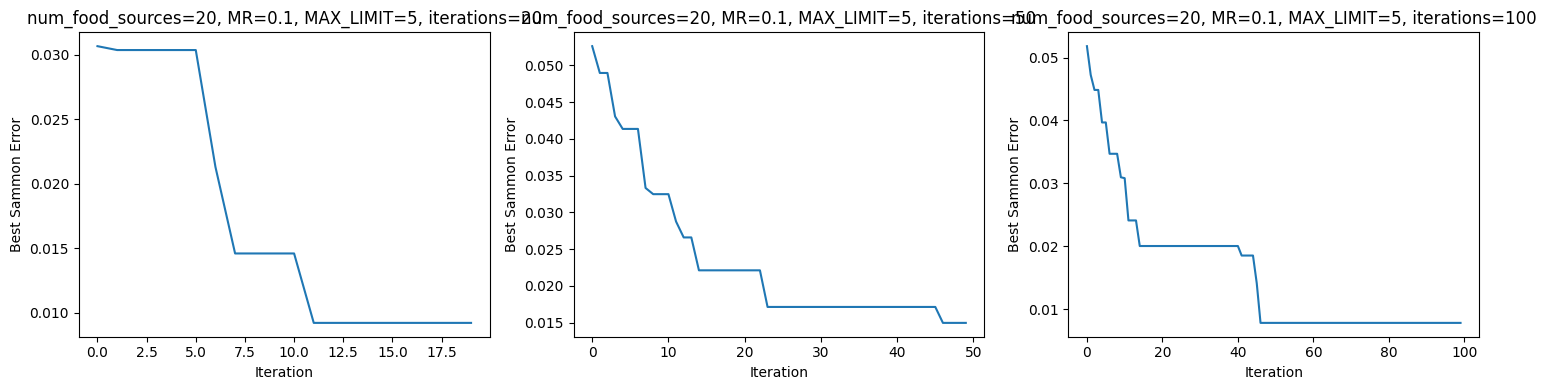

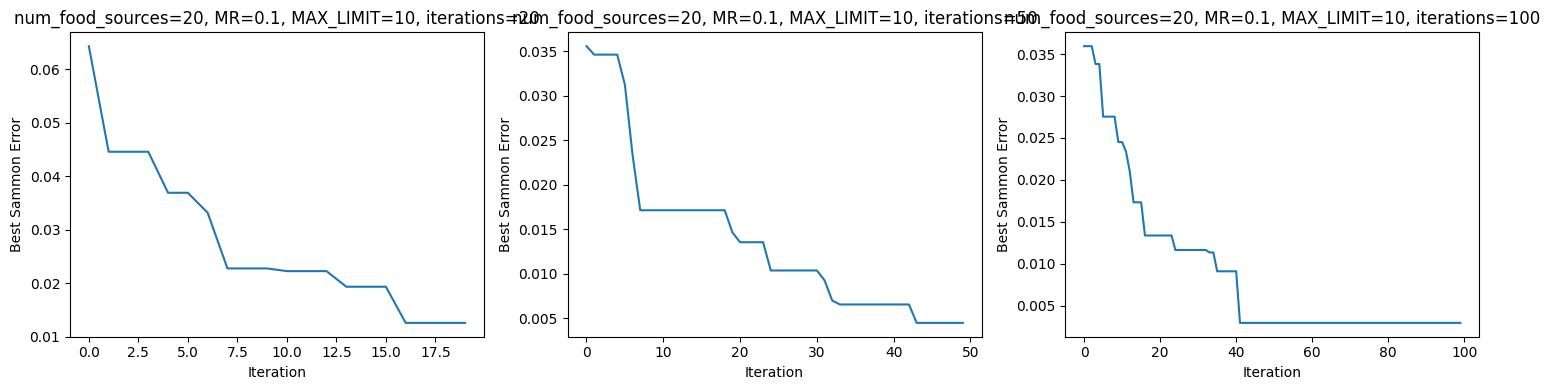

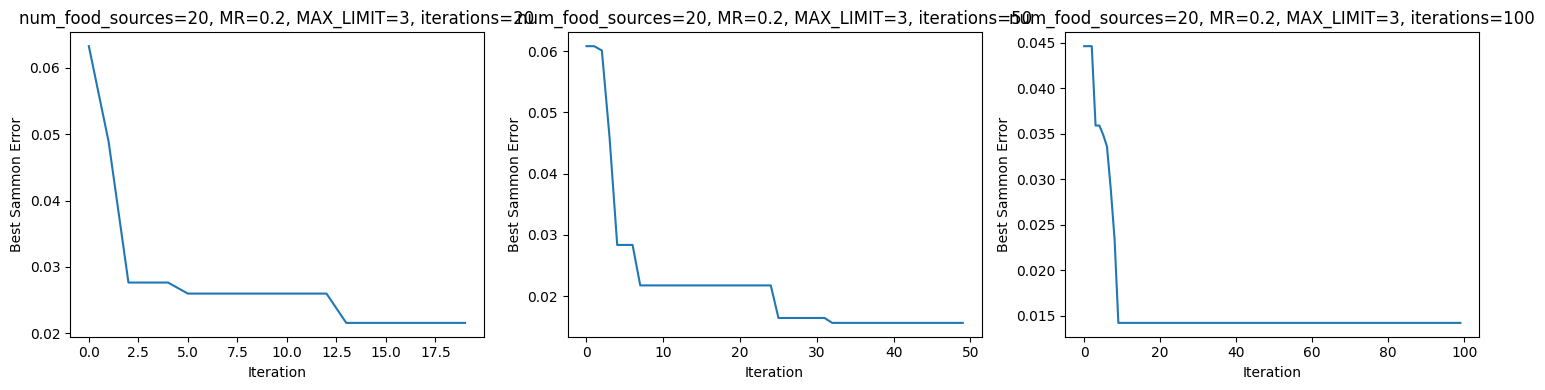

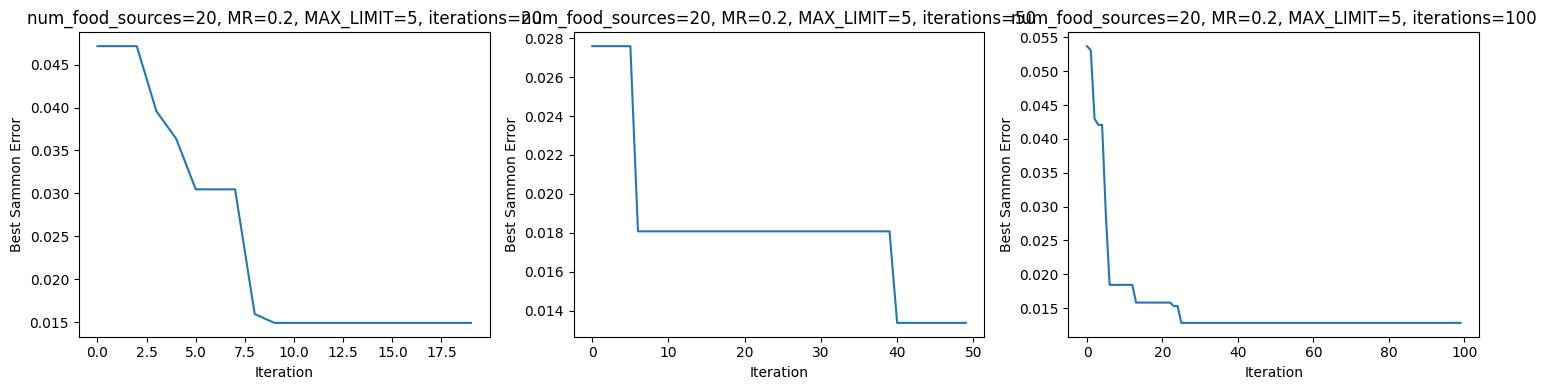

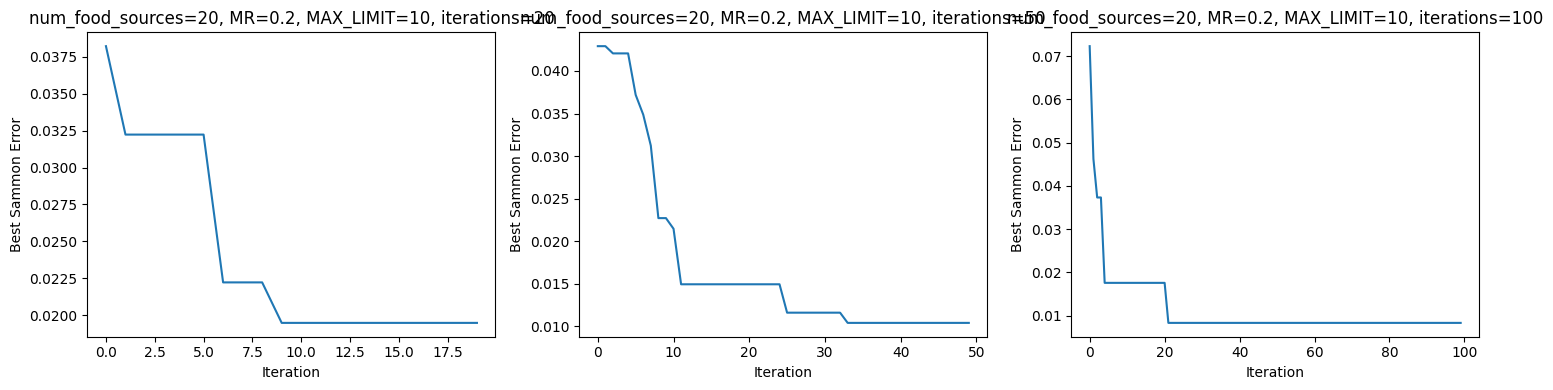

In [28]:
from matplotlib import pyplot as plt

plots_per_row = 3
num_plots = len(results)
num_rows = (num_plots // plots_per_row) + (1 if num_plots % plots_per_row != 0 else 0)

subplot_width = 5
subplot_height = 4
figsize = (subplot_width * plots_per_row, subplot_height * num_rows)

keys = list(results.keys())
values = list(results.values())

for row in range(num_rows):
    fig, axs = plt.subplots(1, plots_per_row, figsize=(subplot_width * plots_per_row, subplot_height))

    axs = np.atleast_1d(axs)

    for col in range(plots_per_row):
        idx = row * plots_per_row + col
        if idx < num_plots:
            key = keys[idx]
            error_history = values[idx]
            axs[col].plot(error_history, label=key)
            axs[col].set_xlabel("Iteration")
            axs[col].set_ylabel("Best Sammon Error")
            axs[col].set_title(key)
        else:
            axs[col].axis('off')

    plt.tight_layout()
    plt.show()